## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,
    FunctionTransformer,
    OrdinalEncoder
)
from sklearn.ensemble import RandomForestRegressor

from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance

import matplotlib.pyplot as plt

import warnings

## Display Settings

In [2]:
pd.set_option("display.max_columns",None) ## to display all columns

In [3]:
sklearn.set_config(transform_output="pandas") ##sikitlearn transformers by default output numpy arrays,which we are changing to pandas df

In [4]:
warnings.filterwarnings("ignore")

## Reading Data

In [5]:
file_path = r"C:\Projects\AWS-SageMaker-Flight_Price_Predictor\data\train.csv"

train = pd.read_csv(file_path)
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-03,Delhi,Cochin,13:15:00,09:25:00,1210,2.0,No Info,10467
1,Jet Airways,2019-05-27,Delhi,Cochin,19:15:00,04:25:00,550,1.0,In-flight meal not included,12898
2,Jet Airways,2019-05-21,Kolkata,Banglore,06:30:00,19:50:00,800,1.0,No Info,14781
3,Jet Airways,2019-05-18,Delhi,Cochin,11:00:00,14:15:00,195,0.0,No Info,9564
4,Air India,2019-05-15,Kolkata,Banglore,14:15:00,16:45:00,150,0.0,No Info,5510


In [6]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## Transformations

### Airline

In [7]:
X_train.airline

0               Air India
1             Jet Airways
2             Jet Airways
3             Jet Airways
4               Air India
              ...        
6690             Spicejet
6691    Multiple Carriers
6692               Indigo
6693          Jet Airways
6694             Spicejet
Name: airline, Length: 6695, dtype: object

In [8]:
airline_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("grouper",RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])

airline_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
6690,0.0,0.0,0.0,0.0,1.0
6691,0.0,0.0,0.0,1.0,0.0
6692,0.0,1.0,0.0,0.0,0.0
6693,0.0,0.0,1.0,0.0,0.0


### date_of_journey

In [9]:
X_train.date_of_journey

0       2019-06-03
1       2019-05-27
2       2019-05-21
3       2019-05-18
4       2019-05-15
           ...    
6690    2019-06-24
6691    2019-06-15
6692    2019-04-21
6693    2019-03-24
6694    2019-03-18
Name: date_of_journey, Length: 6695, dtype: object

In [10]:
features_to_extract = ["month","week","day_of_week","day_of_year"]

doj_transformer = Pipeline(steps= [
    ("dt",DatetimeFeatures(features_to_extract=features_to_extract,yearfirst=True,format="mixed")),
    ("scaler",MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.823529,0.000000,0.796610
1,0.666667,0.764706,0.000000,0.737288
2,0.666667,0.705882,0.166667,0.686441
3,0.666667,0.647059,0.833333,0.661017
4,0.666667,0.647059,0.333333,0.635593
...,...,...,...,...
6690,1.000000,1.000000,0.000000,0.974576
6691,1.000000,0.882353,0.833333,0.898305
6692,0.333333,0.411765,1.000000,0.432203
6693,0.000000,0.176471,1.000000,0.194915


### Source and Destination

In [11]:
X_train.source

0          Delhi
1          Delhi
2        Kolkata
3          Delhi
4        Kolkata
          ...   
6690     Kolkata
6691       Delhi
6692       Delhi
6693     Kolkata
6694    Banglore
Name: source, Length: 6695, dtype: object

In [12]:
X_train.destination

0          Cochin
1          Cochin
2        Banglore
3          Cochin
4        Banglore
          ...    
6690     Banglore
6691       Cochin
6692       Cochin
6693     Banglore
6694    New Delhi
Name: destination, Length: 6695, dtype: object

In [13]:
location_subset = X_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Kolkata,Banglore
3,Delhi,Cochin
4,Kolkata,Banglore
...,...,...
6690,Kolkata,Banglore
6691,Delhi,Cochin
6692,Delhi,Cochin
6693,Kolkata,Banglore


In [14]:
location_pipe1 = Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoder",MeanEncoder()),
    ("scaler",PowerTransformer())
])

location_pipe1.fit_transform(location_subset,y_train).destination.unique()

array([ 1.03800943, -0.19627496, -0.82628736, -1.84331715])

In [15]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [16]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi","New Delhi","Kolkata","Mumbai"]
    return(
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
6690,1,0
6691,1,0
6692,1,0
6693,1,0


In [17]:
location_transformer = FeatureUnion(transformer_list=[                # Feature Union : parallel operations, here it does both operation side side and then combine results 
    ("part1",location_pipe1),
    ("part2",FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.040220,1.038009,1,0
1,1.040220,1.038009,1,0
2,-0.175987,-0.196275,1,0
3,1.040220,1.038009,1,0
4,-0.175987,-0.196275,1,0
...,...,...,...,...
6690,-0.175987,-0.196275,1,0
6691,1.040220,1.038009,1,0
6692,1.040220,1.038009,1,0
6693,-0.175987,-0.196275,1,0


### dep_time and arrival_time

In [18]:
X_train.dep_time

0       13:15:00
1       19:15:00
2       06:30:00
3       11:00:00
4       14:15:00
          ...   
6690    17:10:00
6691    10:20:00
6692    02:00:00
6693    21:10:00
6694    05:45:00
Name: dep_time, Length: 6695, dtype: object

In [19]:
X_train.arrival_time

0       09:25:00
1       04:25:00
2       19:50:00
3       14:15:00
4       16:45:00
          ...   
6690    19:40:00
6691    19:15:00
6692    07:45:00
6693    08:10:00
6694    08:35:00
Name: arrival_time, Length: 6695, dtype: object

In [20]:
time_subset = X_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,13:15:00,09:25:00
1,19:15:00,04:25:00
2,06:30:00,19:50:00
3,11:00:00,14:15:00
4,14:15:00,16:45:00
...,...,...
6690,17:10:00,19:40:00
6691,10:20:00,19:15:00
6692,02:00:00,07:45:00
6693,21:10:00,08:10:00


In [21]:
time_pipe1 = Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.565217,0.272727,0.391304,0.454545
1,0.826087,0.272727,0.173913,0.454545
2,0.260870,0.545455,0.826087,0.909091
3,0.478261,0.000000,0.608696,0.272727
4,0.608696,0.272727,0.695652,0.818182
...,...,...,...,...
6690,0.739130,0.181818,0.826087,0.727273
6691,0.434783,0.363636,0.826087,0.272727
6692,0.086957,0.000000,0.304348,0.818182
6693,0.913043,0.181818,0.347826,0.181818


In [22]:
def part_of_the_day(X,morning=4,afternoon=12,evening=16,night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:,col].between(morning,afternoon,inclusive="left"),
                X_temp.loc[:,col].between(afternoon,evening,inclusive="left"),
                X_temp.loc[:,col].between(evening,night,inclusive="left"),],
                ["morning","afternoon","evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=part_of_the_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,afternoon,morning
1,evening,morning
2,morning,evening
3,morning,afternoon
4,afternoon,evening
...,...,...
6690,evening,evening
6691,morning,evening
6692,night,morning
6693,night,morning


In [23]:
time_pipe2 = Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_the_day)),
    ("encoder",CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
    
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.000000,0.910079
1,0.192393,0.910079
2,1.000000,0.634387
3,1.000000,0.000000
4,0.000000,0.634387
...,...,...
6690,0.192393,0.634387
6691,1.000000,0.634387
6692,0.155241,0.910079
6693,0.155241,0.910079


In [24]:
time_transformer = FeatureUnion(transformer_list=[
    ("time_part1",time_pipe1),
    ("time_part2",time_pipe2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.565217,0.272727,0.391304,0.454545,0.000000,0.910079
1,0.826087,0.272727,0.173913,0.454545,0.192393,0.910079
2,0.260870,0.545455,0.826087,0.909091,1.000000,0.634387
3,0.478261,0.000000,0.608696,0.272727,1.000000,0.000000
4,0.608696,0.272727,0.695652,0.818182,0.000000,0.634387
...,...,...,...,...,...,...
6690,0.739130,0.181818,0.826087,0.727273,0.192393,0.634387
6691,0.434783,0.363636,0.826087,0.272727,1.000000,0.634387
6692,0.086957,0.000000,0.304348,0.818182,0.155241,0.910079
6693,0.913043,0.181818,0.347826,0.181818,0.155241,0.910079


### Duration

In [25]:
X_train[["duration"]]

,duration
0,1210
1,550
2,800
3,195
4,150
...,...
6690,150
6691,535
6692,345
6693,660


In [26]:
## 180 mins short, 180 & 400 medium, >400 long
def flight_duration_categories(X,short=180,medium=400):
    return(
        X
        .assign(flight_duration_categories =  np.select([X.duration.lt(short),
                                                        X.duration.between(short,medium,inclusive="left"),],
                                                        ["short","medium"],
                                                        default="long")
               )
        .drop(columns="duration")
    )

FunctionTransformer(func=flight_duration_categories).fit_transform(X_train[["duration"]])

,flight_duration_categories
0,long
1,long
2,long
3,medium
4,short
...,...
6690,short
6691,long
6692,medium
6693,long


In [27]:
def is_over(X,value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )
FunctionTransformer(func=is_over).fit_transform(X_train.duration.to_frame())

,duration_over_1000
0,1
1,0
2,0
3,0
4,0
...,...
6690,0
6691,0
6692,0
6693,0


In [28]:
duration_pipe1 = Pipeline(steps=[
    ("categories",FunctionTransformer(func=flight_duration_categories)),
    ("encoding",OrdinalEncoder(categories=[["short","medium","long"]]))
])
duration_pipe1.fit_transform(X_train[["duration"]])

,flight_duration_categories
0,2.0
1,2.0
2,2.0
3,1.0
4,0.0
...,...
6690,0.0
6691,2.0
6692,1.0
6693,2.0


In [29]:
(
    X_train
    .duration
    .quantile([0.35,0.5,0.75])
    .values
    .reshape(-1,1)
    .shape
)

(3, 1)

In [30]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25,0.5,0.75],gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self,X,y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }
        
        return self

    def transform(self,X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:,[col]],Y=self.reference_values_[col],gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects,axis=1)

In [31]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000e+00,0.000000e+00,0.0
1,0.000000e+00,1.135971e-88,0.0
2,0.000000e+00,0.000000e+00,0.0
3,7.187782e-28,0.000000e+00,0.0
4,4.248354e-18,0.000000e+00,0.0
...,...,...,...
6690,4.248354e-18,0.000000e+00,0.0
6691,0.000000e+00,8.194013e-40,0.0
6692,0.000000e+00,0.000000e+00,0.0
6693,0.000000e+00,0.000000e+00,0.0


In [32]:
duration_pipe2 = Pipeline(steps=[
    ("rbf",RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2.fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,-0.360200,-0.110408,-0.09325
1,-0.360200,-0.110408,-0.09325
2,-0.360200,-0.110408,-0.09325
3,-0.360200,-0.110408,-0.09325
4,-0.360200,-0.110408,-0.09325
...,...,...,...
6690,-0.360200,-0.110408,-0.09325
6691,-0.360200,-0.110408,-0.09325
6692,-0.360200,-0.110408,-0.09325
6693,-0.360200,-0.110408,-0.09325


In [33]:
duration_union = FeatureUnion(transformer_list=[
    ("part1",duration_pipe1),
    ("part2",duration_pipe2),
    ("part3",FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

In [34]:
duration_transformer = Pipeline(steps=[
    ("outliers",Winsorizer(capping_method="iqr",fold=1.5)),
    ("imputer",SimpleImputer(strategy="median")),
    ("union",duration_union)
])

duration_transformer.fit_transform(X_train.loc[:,["duration"]])

,flight_duration_categories,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_over_1000,duration
0,2.0,-0.360200,-0.110408,-0.09325,1,1.170295
1,2.0,-0.360200,-0.110408,-0.09325,0,-0.159932
2,2.0,-0.360200,-0.110408,-0.09325,0,0.343942
3,1.0,-0.360200,-0.110408,-0.09325,0,-0.875432
4,0.0,-0.360200,-0.110408,-0.09325,0,-0.966129
...,...,...,...,...,...,...
6690,0.0,-0.360200,-0.110408,-0.09325,0,-0.966129
6691,2.0,-0.360200,-0.110408,-0.09325,0,-0.190164
6692,1.0,-0.360200,-0.110408,-0.09325,0,-0.573108
6693,2.0,-0.360200,-0.110408,-0.09325,0,0.061773


### total_stops

In [35]:
X_train.total_stops

0       2.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
6690    0.0
6691    1.0
6692    1.0
6693    1.0
6694    0.0
Name: total_stops, Length: 6695, dtype: float64

In [36]:
def is_direct(X):
    return (
        X
        .assign(
            is_direct_flight=X.total_stops.eq(0).astype(int)
        )
    )

In [37]:
total_stops_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("direct",FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:,["total_stops"]])

,total_stops,is_direct_flight
0,2.0,0
1,1.0,0
2,1.0,0
3,0.0,1
4,0.0,1
...,...,...
6690,0.0,1
6691,1.0,0
6692,1.0,0
6693,1.0,0


## additional_info

In [38]:
X_train.additional_info

0                            No Info
1        In-flight meal not included
2                            No Info
3                            No Info
4                            No Info
                    ...             
6690                         No Info
6691                         No Info
6692                         No Info
6693     In-flight meal not included
6694    No check-in baggage included
Name: additional_info, Length: 6695, dtype: object

In [39]:
additional_info_pipe1 = Pipeline(steps=[
    ("group",RareLabelEncoder(tol=0.1,n_categories=2,replace_with="other")),
    ("encoder",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])

additional_info_pipe1.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,0.0,1.0,0.0
6693,1.0,0.0,0.0


In [40]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [41]:
info_union = FeatureUnion(transformer_list=[
    ("part1",additional_info_pipe1),
    ("part2",FunctionTransformer(func=have_info))
])

In [42]:
additional_info_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="constant",fill_value="unknown")),
    ("union",info_union)
])

additional_info_transformer.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,0.0,1.0,0.0,0
6693,1.0,0.0,0.0,1


## Column Transformer

In [43]:
column_transformer = ColumnTransformer(transformers=[
    ("airline",airline_transformer,["airline"]),
    ("doj",doj_transformer,["date_of_journey"]),
    ("location",location_transformer,["source","destination"]),
    ("time",time_transformer,["dep_time","arrival_time"]),
    ("dur",duration_transformer,["duration"]),
    ("stops",total_stops_transformer,["total_stops"]),
    ("info",additional_info_transformer,["additional_info"])
],remainder="passthrough")

In [44]:
column_transformer.fit_transform(X_train,y_train)

,airline__airline_Air India,airline__airline_Indigo,airline__airline_Jet Airways,airline__airline_Multiple Carriers,airline__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__flight_duration_categories,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,1.040220,1.038009,1,0,0.565217,0.272727,0.391304,0.454545,0.000000,0.910079,2.0,-0.360200,-0.110408,-0.09325,1,1.170295,2.0,0,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,1.040220,1.038009,1,0,0.826087,0.272727,0.173913,0.454545,0.192393,0.910079,2.0,-0.360200,-0.110408,-0.09325,0,-0.159932,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,-0.175987,-0.196275,1,0,0.260870,0.545455,0.826087,0.909091,1.000000,0.634387,2.0,-0.360200,-0.110408,-0.09325,0,0.343942,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.040220,1.038009,1,0,0.478261,0.000000,0.608696,0.272727,1.000000,0.000000,1.0,-0.360200,-0.110408,-0.09325,0,-0.875432,0.0,1,0.0,1.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,-0.175987,-0.196275,1,0,0.608696,0.272727,0.695652,0.818182,0.000000,0.634387,0.0,-0.360200,-0.110408,-0.09325,0,-0.966129,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.974576,-0.175987,-0.196275,1,0,0.739130,0.181818,0.826087,0.727273,0.192393,0.634387,0.0,-0.360200,-0.110408,-0.09325,0,-0.966129,0.0,1,0.0,1.0,0.0,0
6691,0.0,0.0,0.0,1.0,0.0,1.000000,0.882353,0.833333,0.898305,1.040220,1.038009,1,0,0.434783,0.363636,0.826087,0.272727,1.000000,0.634387,2.0,-0.360200,-0.110408,-0.09325,0,-0.190164,1.0,0,0.0,1.0,0.0,0
6692,0.0,1.0,0.0,0.0,0.0,0.333333,0.411765,1.000000,0.432203,1.040220,1.038009,1,0,0.086957,0.000000,0.304348,0.818182,0.155241,0.910079,1.0,-0.360200,-0.110408,-0.09325,0,-0.573108,1.0,0,0.0,1.0,0.0,0
6693,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,1.000000,0.194915,-0.175987,-0.196275,1,0,0.913043,0.181818,0.347826,0.181818,0.155241,0.910079,2.0,-0.360200,-0.110408,-0.09325,0,0.061773,1.0,0,1.0,0.0,0.0,1


## Feature Selection

In [45]:
estimator = RandomForestRegressor(n_estimators=10,max_depth=3,random_state=9)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.1
)

## Final preprocessor pipeline

In [46]:
preprocessor = Pipeline(steps=[
    ("column_tranformer",column_transformer),
    ("selector",selector)
])

preprocessor.fit_transform(X_train,y_train)

,airline__airline_Indigo,airline__airline_Jet Airways,airline__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__flight_duration_categories,dur__duration_rbf_25,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,0.823529,0.796610,1.040220,1.038009,2.0,-0.360200,1,1.170295,2.0,0
1,0.0,1.0,0.0,0.764706,0.737288,1.040220,1.038009,2.0,-0.360200,0,-0.159932,1.0,0
2,0.0,1.0,0.0,0.705882,0.686441,-0.175987,-0.196275,2.0,-0.360200,0,0.343942,1.0,0
3,0.0,1.0,0.0,0.647059,0.661017,1.040220,1.038009,1.0,-0.360200,0,-0.875432,0.0,1
4,0.0,0.0,0.0,0.647059,0.635593,-0.175987,-0.196275,0.0,-0.360200,0,-0.966129,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,0.0,1.0,1.000000,0.974576,-0.175987,-0.196275,0.0,-0.360200,0,-0.966129,0.0,1
6691,0.0,0.0,0.0,0.882353,0.898305,1.040220,1.038009,2.0,-0.360200,0,-0.190164,1.0,0
6692,1.0,0.0,0.0,0.411765,0.432203,1.040220,1.038009,1.0,-0.360200,0,-0.573108,1.0,0
6693,0.0,1.0,0.0,0.176471,0.194915,-0.175987,-0.196275,2.0,-0.360200,0,0.061773,1.0,0


In [47]:
preprocessor

Pipeline(steps=[('column_tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('airline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(st...
                                                                                                                                     replace_with='other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x0000021671C07420>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=9),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [48]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'airline__airline_Air India': 0.0013772186753392794,
 'airline__airline_Indigo': 0.13161384542659285,
 'airline__airline_Jet Airways': 0.17553346918098633,
 'airline__airline_Multiple Carriers': 0.019019988240027225,
 'airline__airline_Other': 0.11486135766169987,
 'doj__date_of_journey_month': 0.08684833624248996,
 'doj__date_of_journey_week': 0.18219769412429954,
 'doj__date_of_journey_day_of_week': 0.003603647941030186,
 'doj__date_of_journey_day_of_year': 0.21562743349477678,
 'location__source': 0.1266624292060907,
 'location__destination': 0.13107844083727535,
 'location__source_is_north': 0.02956625242702038,
 'location__destination_is_north': 0.02956625242702038,
 'time__dep_time_hour': 0.013151293622142438,
 'time__dep_time_minute': 0.03517377209579212,
 'time__arrival_time_hour': 0.07574253026278943,
 'time__arrival_time_minute': 0.03142617354820609,
 'time__dep_time_part_of_day': -0.001782680973714997,
 'time__arrival_time_part_of_day': 0.030456848700304812,
 'dur__flight_d

In [270]:
sorted_feature_imp = dict(sorted(feature_performances.items(),key=lambda val:val[1]))
sorted_feature_imp

{'dur__duration_rbf_75': -0.003426030004765638,
 'info__additional_info_No Info': -0.0024357858963159895,
 'info__additional_info': -0.0024357858963159895,
 'info__additional_info_In-flight meal not included': -0.0018973588964235806,
 'time__dep_time_part_of_day': -0.001782680973714997,
 'dur__duration_rbf_50': 0.0010387667864738548,
 'airline__airline_Air India': 0.0013772186753392794,
 'doj__date_of_journey_day_of_week': 0.003603647941030186,
 'time__dep_time_hour': 0.013151293622142438,
 'info__additional_info_other': 0.01445955689734509,
 'airline__airline_Multiple Carriers': 0.019019988240027225,
 'location__source_is_north': 0.02956625242702038,
 'location__destination_is_north': 0.02956625242702038,
 'time__arrival_time_part_of_day': 0.030456848700304812,
 'time__arrival_time_minute': 0.03142617354820609,
 'time__dep_time_minute': 0.03517377209579212,
 'time__arrival_time_hour': 0.07574253026278943,
 'doj__date_of_journey_month': 0.08684833624248996,
 'dur__duration_rbf_25': 0.1

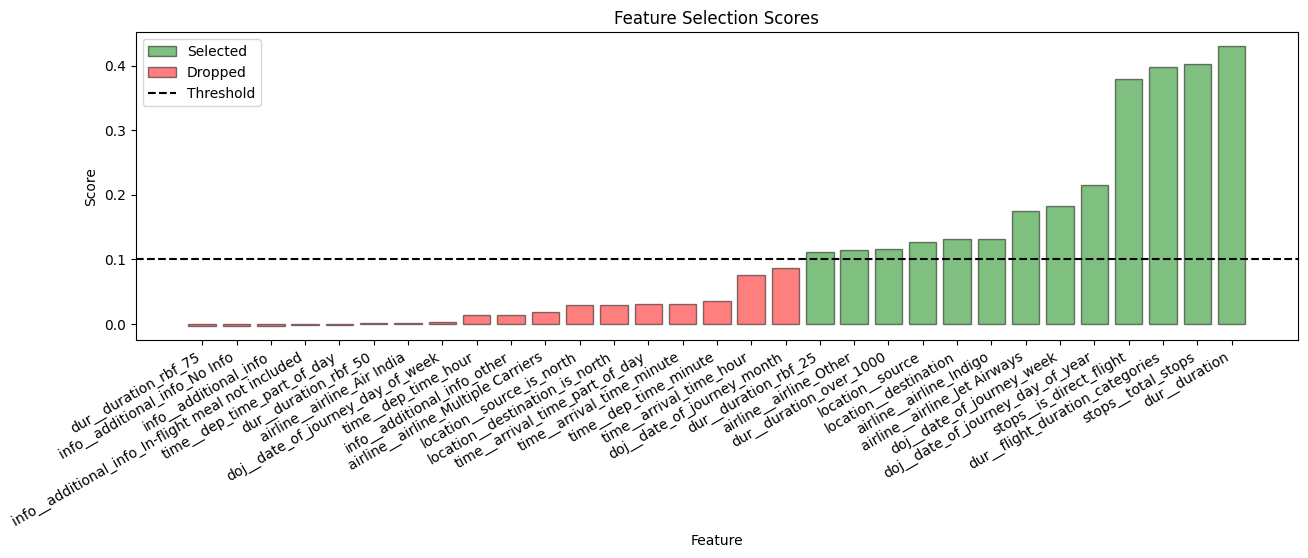

In [274]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feature_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feature_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feature_imp)),
	labels=list(sorted_feature_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()
